# Herron Topic 3 - Multifactor Models

This notebook covers multifactor models, emphasizing the capital asset pricing model (CAPM) and the Fama-French three-factor model (FF3).
Ivo Welch provides a high-level review of the CAPM and multifactor models in [Chapter 10 of his free *Corporate Finance* textbook](https://book.ivo-welch.info/read/source5.mba/10-capm.pdf).
The [Wikipedia page for the CAPM](https://en.wikipedia.org/wiki/Capital_asset_pricing_model) is surprisingly good and includes its assumptions and shortcomings.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pandas_datareader as pdr
import seaborn as sns
import statsmodels.formula.api as smf
import yfinance as yf

In [2]:
%precision 4
pd.options.display.float_format = '{:.4f}'.format
%config InlineBackend.figure_format = 'retina'

## The Capital Asset Pricing Model (CAPM)

The CAPM explains the relation between non-diversifiable risk and expected return and has applications throughout finance.
We use the CAPM to 
    estimate expected rates of return in investment analysis,
    estimate costs of capital in corporate finance, 
    and
    assemble portfolios with a given risk-return tradeoff in portfolio management.
The formula for the CAPM is $E(r_i) = r_f + \beta_i [E(r_M) - r_f]$, where:

1. $r_f$ is the risk-free rate of return,
2. $\beta_i$ is the measure of non-diversifiable risk for asset $i$, and
3. $E(r_M)$ is the expected rate of return on the market.

The value-weighted mean of all $\beta_i$s is 1 by construction, but a range of $\beta_i$s is possible:

1. $\beta_i < -1$: Asset $i$ moves in the opposite direction as the market, in larger magnitudes
2. $-1 \leq \beta_i < 0$: Asset $i$ moves in the opposite direction as the market
3. $\beta_i = 0$: Asset $i$ has no correlation between with the market
4. $0 < \beta_i \leq 1$: Asset $i$ moves in the same direction as the market, in smaller magnitudes
5. $\beta_i = 1$: Asset $i$ moves in the same direction with the same magnitude as the market
6. $\beta_i > 1$: Asset $i$ moves in the same direction as the market, in larger magnitudes

We will follow Bodie, Kane, and Marcus's notation:

1. Lowercase $r_i$ is the *raw* return on asset $i$
2. Uppercase $R_i$ is the *excess* return on asset $i$
3. So, $R_i = r_i - r_f$ and $R_M = r_M - r_f$

### $\beta$ Estimation

We can use three approaches to estimate CAPM $\beta_i$s:

1. Use the covariance and variance of excess returns: $\beta_i = \frac{Cov(r_i - r_f, r_M - r_f)}{Var(r_M - r_f)}$
2. Use the correlation and standard deviations of excess returns: $\beta_i = \rho_{i, M} \frac{\sigma_i}{\sigma_M}$
1. Use a linear regression of asset excess returns $r_i-r_f$ on market excess returns $r_M-r_f$

The first two approaches are computationally faster.
However, the third approach also estimates the intercept $\alpha_i$ and several goodness-of-fit statistics.
We can use Apple (AAPL) to convince ourselves these three approaches are equivalent.

***Note, we will leave returns in percent to make it easier to interpret our regression output!***
Leaving returns in percent does not affect $\beta$ estimates (slopes) but makes $\alpha$ estimates (intercepts) easier to interpret because they are in percents instead of decimals.

In [3]:
aapl = (
    yf.download(tickers='AAPL')
    .rename_axis(columns='Variable')
)

aapl.tail()

[*********************100%%**********************]  1 of 1 completed


Variable,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2024-03-22,171.7600,173.0500,170.0600,172.2800,172.2800,71106600
2024-03-25,170.5700,171.9400,169.4500,170.8500,170.8500,54288300
2024-03-26,170.0000,171.4200,169.5800,169.7100,169.7100,57388400
2024-03-27,170.4100,173.6000,170.1100,173.3100,173.3100,60273300
2024-03-28,171.7500,172.2300,170.5100,171.4800,171.4800,65623100


In [5]:
ff = (
    pdr.DataReader(
        name='F-F_Research_Data_Factors_daily',
        data_source='famafrench',
        start='1900',
    )
)

ff[0].tail()

C:\Users\r.herron\AppData\Local\Temp\ipykernel_25232\3958803354.py:2: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  pdr.DataReader(


,Mkt-RF,SMB,HML,RF
Date,,,,
2024-01-25,0.4600,0.0400,0.5600,0.0220
2024-01-26,-0.0200,0.4000,-0.2700,0.0220
2024-01-29,0.8500,1.0700,-0.5900,0.0220
2024-01-30,-0.1300,-1.2600,0.8400,0.0220
2024-01-31,-1.7400,-0.9200,-0.3000,0.0220


In [6]:
aapl = (
    aapl
    .join(ff[0])
    .rename(columns={'Mkt-RF': 'RM', 'RF': 'rf'})
    .assign(
        ri=lambda x: x['Adj Close'].pct_change().mul(100),
        Ri = lambda x: x['ri'] - x['rf'],
        rM=lambda x: x['RM'] + x['rf']
    )
)

aapl.head()

,Open,High,Low,Close,Adj Close,Volume,RM,SMB,HML,rf,ri,Ri,rM
Date,,,,,,,,,,,,,
1980-12-12,0.1283,0.1289,0.1283,0.1283,0.0992,469033600,1.3800,-0.0100,-1.0500,0.0590,NaN,NaN,1.4390
1980-12-15,0.1222,0.1222,0.1217,0.1217,0.0940,175884800,0.1100,0.2500,-0.4600,0.0590,-5.2170,-5.2760,0.1690
1980-12-16,0.1133,0.1133,0.1127,0.1127,0.0871,105728000,0.7100,-0.7500,-0.4700,0.0590,-7.3398,-7.3988,0.7690
1980-12-17,0.1155,0.1161,0.1155,0.1155,0.0893,86441600,1.5200,-0.8600,-0.3400,0.0590,2.4751,2.4161,1.5790
1980-12-18,0.1189,0.1194,0.1189,0.1189,0.0919,73449600,0.4100,0.2200,1.2600,0.0590,2.8992,2.8402,0.4690


#### Covariance and Variance Approach to Estimate $\beta$

In [7]:
vcv = aapl[['Ri', 'RM']].dropna().cov()

vcv

,Ri,RM
Ri,7.8421,1.5508
RM,1.5508,1.2312


In [8]:
print(f"Apple beta from cov/var: {vcv.loc['Ri', 'RM'] / vcv.loc['RM', 'RM']:0.4f}")

Apple beta from cov/var: 1.2596


#### Correlation and Standard Deviation Approach to Estimate $\beta$

In [9]:
_ = aapl[['Ri', 'RM']].dropna()
rho = _.corr()
sigma = _.std()

print(f'rho:\n{rho}\n\nsigma:\n{sigma}')

rho:
       Ri     RM
Ri 1.0000 0.4991
RM 0.4991 1.0000

sigma:
Ri   2.8004
RM   1.1096
dtype: float64


In [10]:
print(f"Apple beta from rho and sigmas: {rho.loc['Ri', 'RM'] * sigma.loc['Ri'] / sigma.loc['RM']:0.4f}")

Apple beta from rho and sigmas: 1.2596


#### Linear Regression Approach to Estimate $\beta$

We will use the statsmodels package to estimate linear regressions.
I typically use the formula application programming interface (API).

With statsmodels (and most Python model estimation packages), we have three steps:

1. Specify the model with the `smf.ols()` function
1. Fit the model with the `.fit()` method
1. Summarize the model with the `.summary()` method

In [11]:
model = smf.ols(formula='Ri ~ RM', data=aapl)
fit = model.fit()
summary = fit.summary()

summary

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                     Ri   R-squared:                       0.249
Model:                            OLS   Adj. R-squared:                  0.249
Method:                 Least Squares   F-statistic:                     3606.
Date:                Fri, 29 Mar 2024   Prob (F-statistic):               0.00
Time:                        08:15:40   Log-Likelihood:                -25067.
No. Observations:               10873   AIC:                         5.014e+04
Df Residuals:                   10871   BIC:                         5.015e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.0514      0.023      2.207      0.027       0.006       0.097
RM             1.2596      0.021     60.049      0.000       1.218       1.301
==============================================================================
Omnibus:                     3230.837   Durbin-Watson:                   1.916
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           334498.501
Skew:                          -0.379   Prob(JB):                         0.00
Kurtosis:                      30.162   Cond. No.                         1.11
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

We can recover the coefficient estimates from the `fit` object's `params` attribute.

In [12]:
fit.params

Intercept   0.0514
RM          1.2596
dtype: float64

In [13]:
print(f"Apple beta from linear regression: {fit.params['RM']:0.4f}")

Apple beta from linear regression: 1.2596


We can chain these operations, but it often makes sense to save the intermediate results to model and fit objects.

In [14]:
smf.ols('Ri ~ RM', aapl).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                     Ri   R-squared:                       0.249
Model:                            OLS   Adj. R-squared:                  0.249
Method:                 Least Squares   F-statistic:                     3606.
Date:                Fri, 29 Mar 2024   Prob (F-statistic):               0.00
Time:                        08:16:28   Log-Likelihood:                -25067.
No. Observations:               10873   AIC:                         5.014e+04
Df Residuals:                   10871   BIC:                         5.015e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.0514      0.023      2.207      0.027       0.006       0.097
RM             1.2596      0.021     60.049      0.000       1.218       1.301
==============================================================================
Omnibus:                     3230.837   Durbin-Watson:                   1.916
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           334498.501
Skew:                          -0.379   Prob(JB):                         0.00
Kurtosis:                      30.162   Cond. No.                         1.11
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### How to Visualize $\beta$

We can visualize $\beta$ as a scatterplot of `Ri` versus `RM`, where $\beta$ is the slope of the best-fit line. 
We can use the seaborn package's `regplot()` to add this best-fit line.
We can write three functions to more easily make pretty plots.

In [15]:
def get_beta(x):
    vcv = x.dropna().cov()
    beta = vcv.loc['Ri', 'RM'] / vcv.loc['RM', 'RM']
    return r'$\beta=$' + f'{beta: 0.4f}'

In [16]:
def get_dates(x):
    y = x.dropna()
    return f'from {y.index[0]:%b %d, %Y} to {y.index[-1]:%b %d, %Y}'

In [17]:
def plot_beta(x, freq, name):
    sns.regplot(
        data=x,
        x='RM',
        y='Ri',
        scatter_kws={'alpha': 0.1},
        line_kws={'label': x.pipe(get_beta)}
    )
    plt.legend()
    plt.xlabel(f'Market {freq} Excess Return (%)')
    plt.ylabel(f'Stock {freq} Excess Return (%)')
    plt.title(
        r'$\beta$ Plot with ' + 
        f'{freq} Excess Returns for {name}' + 
        '\n' + 
        x.pipe(get_dates)
    )


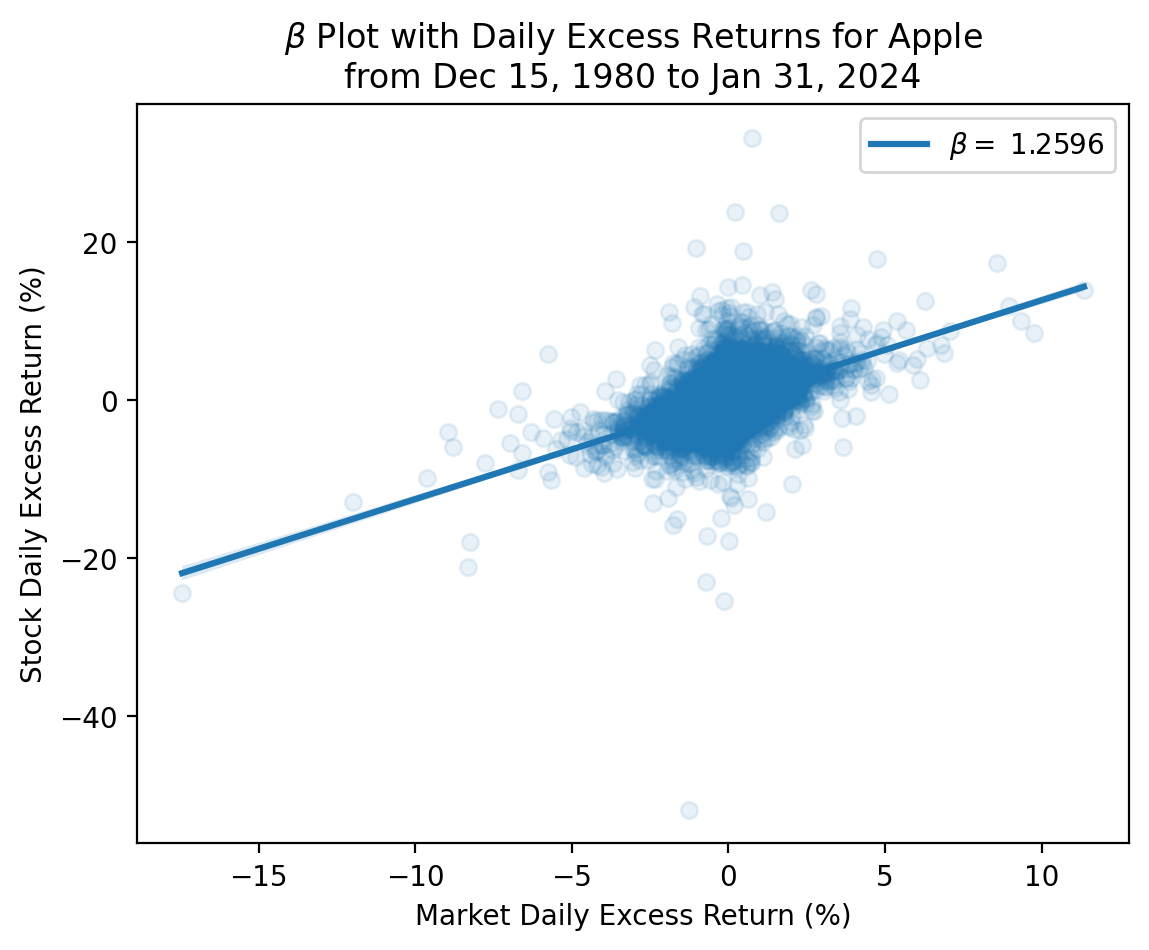

In [18]:
(
    aapl
    [['Ri', 'RM']]
    .dropna()
    .pipe(plot_beta, freq='Daily', name='Apple')
)

We see a strong relation between Apple and market excess returns, but there is a lot of unexplained variation in Apple excess returns because Apple has changed a lot over the past 45 years!
The best practice is to estimate $\beta$ with one to three years of daily data.

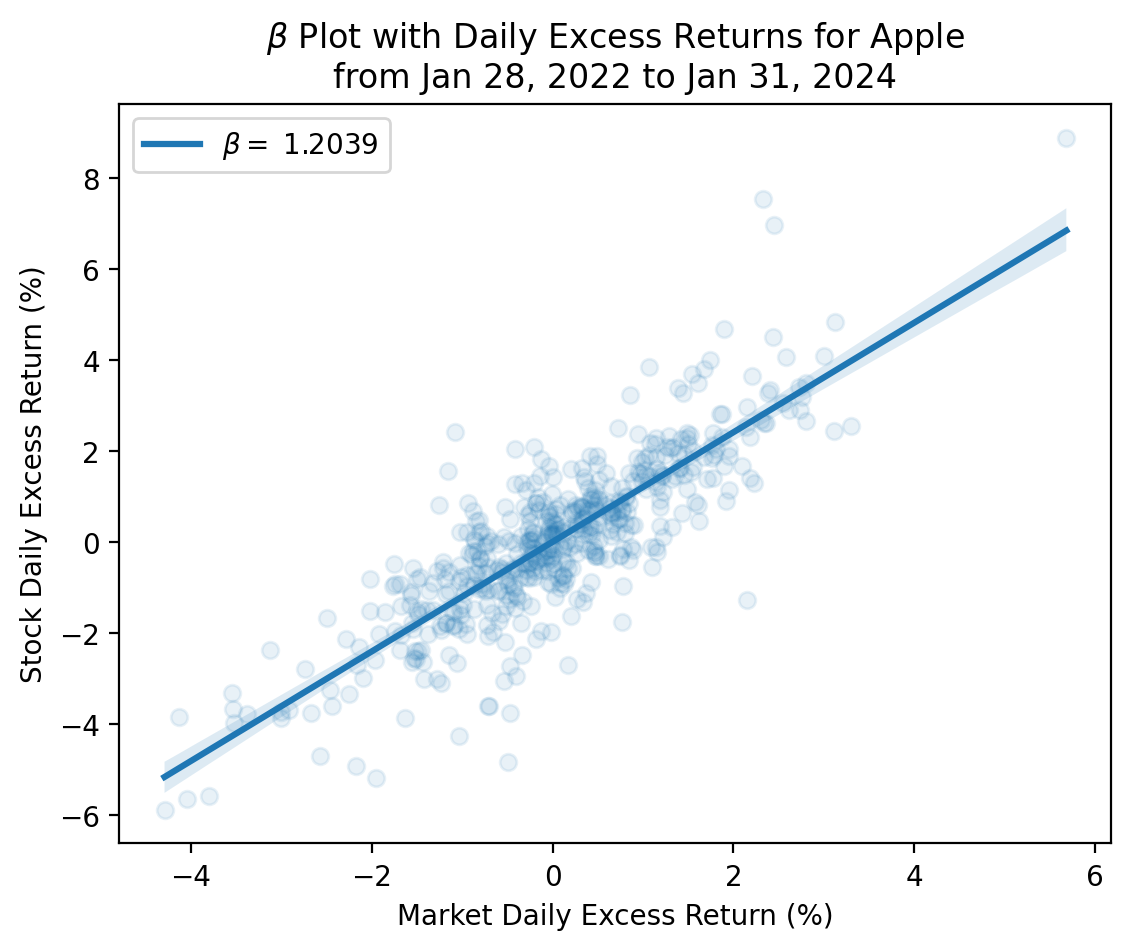

In [19]:
(
    aapl
    [['Ri', 'RM']]
    .dropna()
    .iloc[-504:]
    .pipe(plot_beta, freq='Daily', name='Apple')
)

### The Security Market Line (SML)

The SML visualizes the CAPM.
We can visualize $E(r_i) = r_f + \beta_i [E(r_M) - r_f]$ as $y = b + xm$, where:

1. The equity premium $E(r_M) - r_f$ is the slope $m$ of the SML
1. The risk-free rate of return $r_f$ is its intercept $b$ of the SML

We will explore the SML more in the practice notebook.

### How well does the CAPM work?

The CAPM *appears* to work well as a single-period model.
We can see this with portfolios formed on $\beta$ from Ken French.

In [20]:
ff_beta = pdr.DataReader(
    name='Portfolios_Formed_on_BETA',
    data_source='famafrench',
    start='1900'
)

C:\Users\r.herron\AppData\Local\Temp\ipykernel_25232\1792222927.py:1: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  ff_beta = pdr.DataReader(
C:\Users\r.herron\AppData\Local\Temp\ipykernel_25232\1792222927.py:1: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  ff_beta = pdr.DataReader(
C:\Users\r.herron\AppData\Local\Temp\ipykernel_25232\1792222927.py:1: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  ff_beta = pdr.DataReader(
C:\Users\r.herron\AppData\Local\Temp\ipykernel_25232\1792222927.py:1: FutureWarning: The argument 'date_parse

In [21]:
print(ff_beta['DESCR'])

Portfolios Formed on BETA
-------------------------

This file was created by CMPT_BETA_RETS using the 202401 CRSP database. It contains value- and equal-weighted returns for portfolios formed on BETA. The portfolios are constructed at the end of June. Beta is estimated using monthly returns for the past 60 months (requiring at least 24 months with non-missing returns). Beta is estimated using the Scholes-Williams method. Annual returns are from January to December. Missing data are indicated by -99.99 or -999. The break points include utilities and include financials. The portfolios include utilities and include financials. Copyright 2024 Kenneth R. French

  0 : Value Weighted Returns -- Monthly (727 rows x 15 cols)
  1 : Equal Weighted Returns -- Monthly (727 rows x 15 cols)
  2 : Value Weighted Returns -- Annual from January to December (60 rows x 15 cols)
  3 : Equal Weighted Returns -- Annual from January to December (60 rows x 15 cols)
  4 : Number of Firms in Portfolios (727 ro

This file contains seven data frames.
We want the data frame at `[2]`, which contains the annual returns on two sets of portfolios formed on the previous year's $\beta$s.

In [22]:
ff_beta[2].head()

,Lo 20,Qnt 2,Qnt 3,Qnt 4,Hi 20,Lo 10,Dec 2,Dec 3,Dec 4,Dec 5,Dec 6,Dec 7,Dec 8,Dec 9,Hi 10
Date,,,,,,,,,,,,,,,
1964,16.8700,19.7500,17.6600,8.7300,12.5500,24.7000,13.5900,20.2700,19.0100,19.7900,15.6800,9.7900,8.2300,13.6000,11.6600
1965,8.7200,6.9800,15.4000,24.8800,49.6700,12.4400,6.7600,10.0200,5.2500,13.7100,17.1100,20.7000,28.2800,42.0700,57.7300
1966,-9.2500,-12.1700,-9.1000,-2.7300,-2.2000,-9.4300,-9.4400,-12.5700,-12.1600,-7.5000,-10.5600,-6.2200,0.1800,-3.3100,-0.9400
1967,13.4300,22.0600,31.9500,42.7900,51.1500,8.9200,18.6400,22.7900,21.6500,31.1100,34.1600,40.5700,44.4000,41.6100,59.7800
1968,15.8100,9.1200,13.6400,14.4300,24.2400,18.4800,12.8400,14.5100,5.8400,12.6600,14.7500,19.0800,10.5400,23.2500,25.2900


We can plot the mean annual return on each of the five portfolios in the first set of portflios.
We do not need to annualize these numbers because they are the means of annual returns.
The vertical black bars indicate the 95% confidence intervals for our mean annual return estimates.

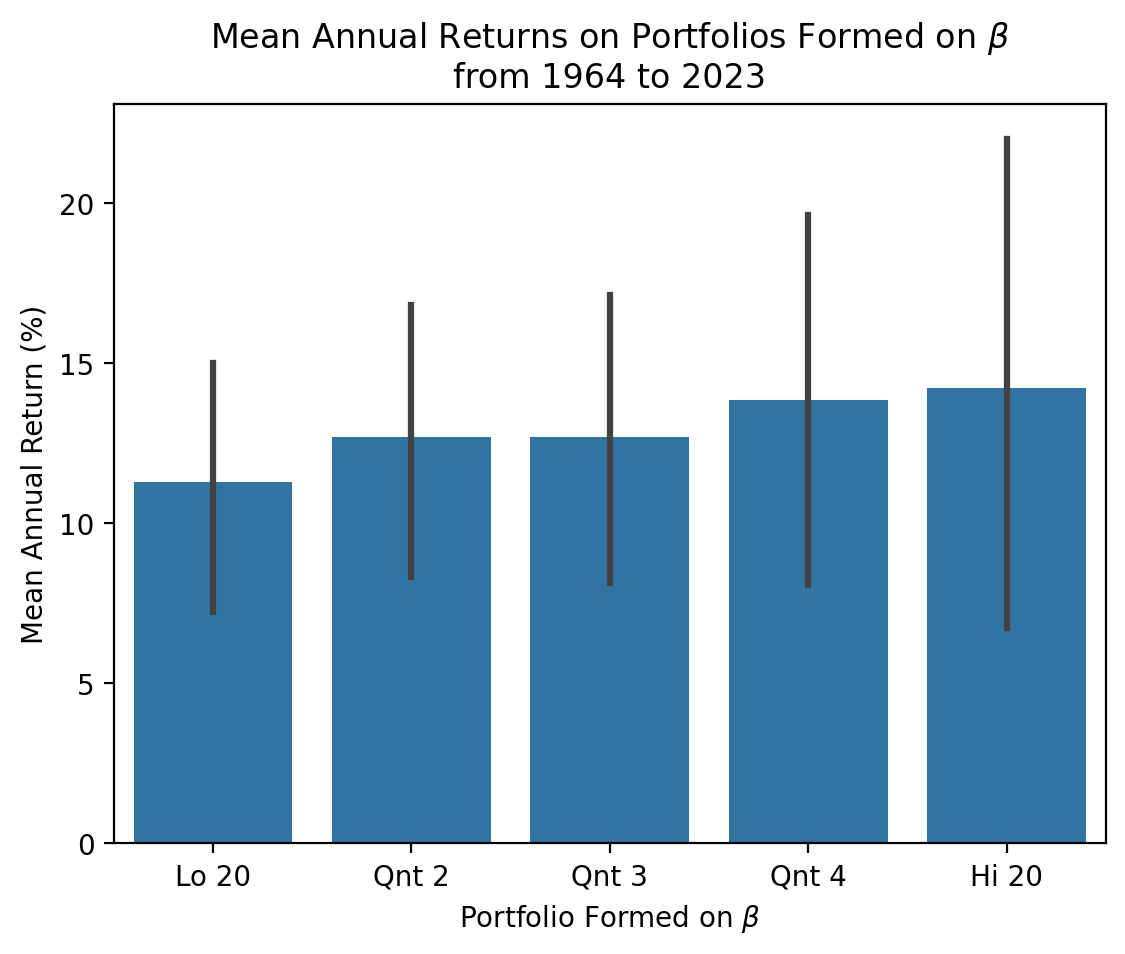

In [23]:
_ = (
    ff_beta
    [2]
    .iloc[:, :5]
    .rename_axis(columns='Portfolio')
)

sns.barplot(
    data=_.stack().to_frame('Return').reset_index(),
    x='Portfolio',
    y='Return'
)

plt.xlabel(r'Portfolio Formed on $\beta$')
plt.ylabel('Mean Annual Return (%)')
plt.title(
    r'Mean Annual Returns on Portfolios Formed on $\beta$' + 
    '\n' + 
    f'from {_.index[0]} to {_.index[-1]}'
)
plt.show()

We can think of the plot above as a binned plot of the SML.
The x-axis above is an ordinal measure of $\beta$, and the y-axis above is the mean return.
Recall the slope of the SML is the market risk premium.
If the market risk premium is too low, then high $\beta$ stocks do not have high enough returns.
We can see this failure of the CAPM by plotting long-term or cumulative returns on these five portfolios.

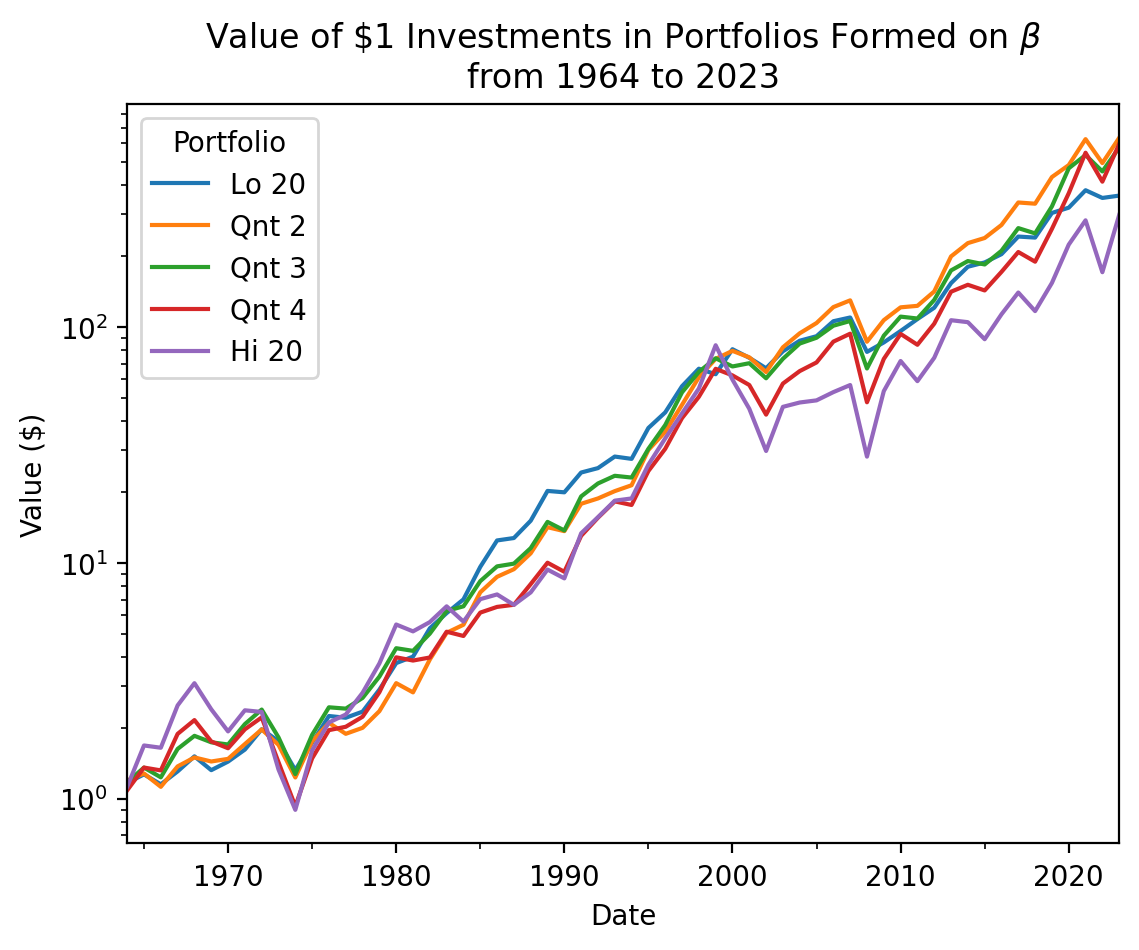

In [24]:
_ = (
    ff_beta
    [2]
    .iloc[:, :5]
    .rename_axis(columns='Portfolio')
)

_.div(100).add(1).cumprod().plot()
plt.semilogy()
plt.ylabel('Value ($)')
plt.title(
    r'Value of \$1 Investments in Portfolios Formed on $\beta$' + 
    '\n' + 
    f'from {_.index[0]} to {_.index[-1]}'
)
plt.show()

In the plot above, the highest-$\beta$ portfolio has the lowest cumulative returns!
The log scale masks a lot of variation, too!

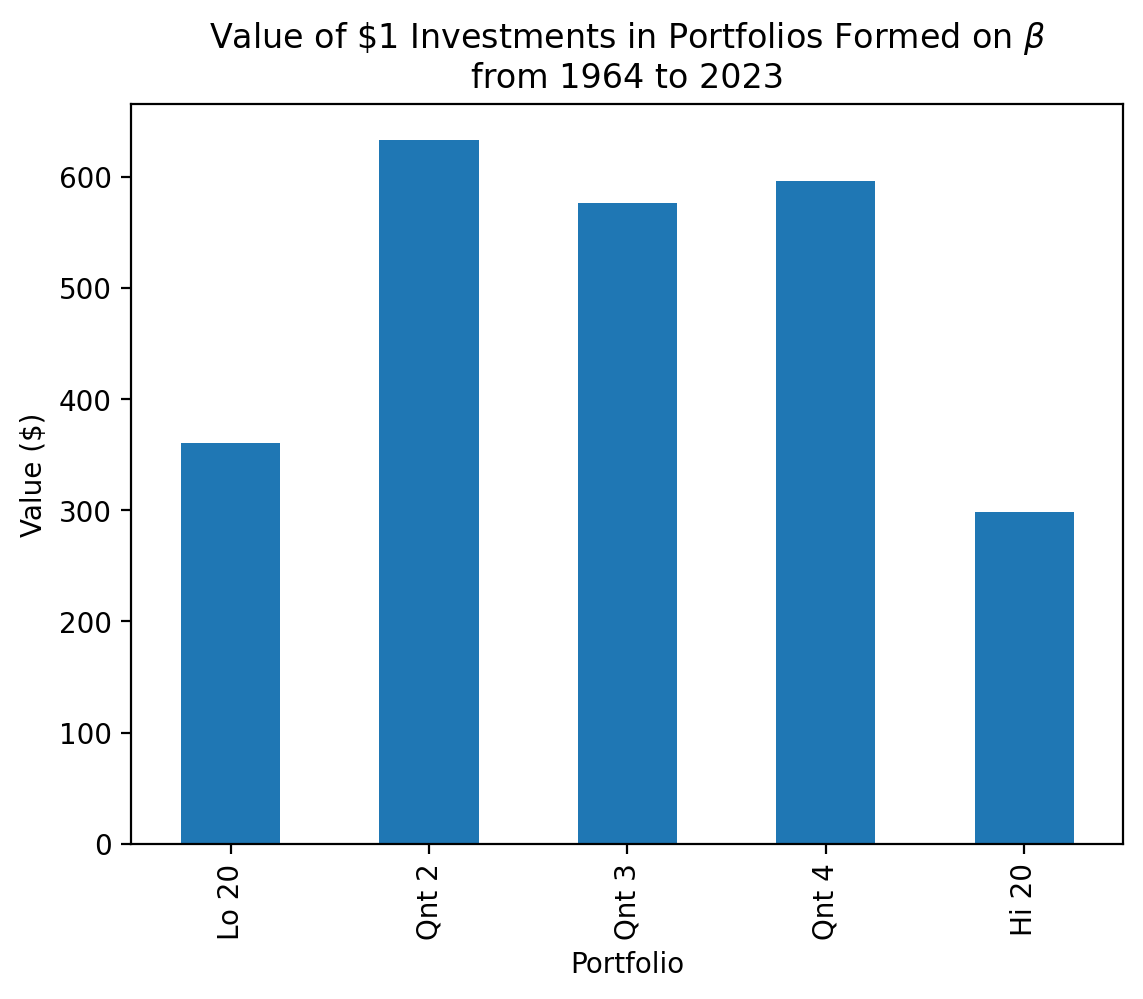

In [25]:
_ = (
    ff_beta
    [2]
    .iloc[:, :5]
    .rename_axis(columns='Portfolio')
)

_.div(100).add(1).prod().plot(kind='bar')
plt.ylabel('Value ($)')
plt.title(
    r'Value of \$1 Investments in Portfolios Formed on $\beta$' + 
    '\n' + 
    f'from {_.index[0]} to {_.index[-1]}'
)
plt.show()

If the CAPM does not work well, especially over the horizons we use it for (e.g., capital budgeting), why do we continue to learn it?

1. The CAPM works well *across* asset classes. We will explore this more in the practice notebook.
1. The CAPM intuition that diversification matters is correct and important
1. The CAPM assigns high costs of capital to high-$\beta$ projects (i.e., high-risk projects), which is a hidden benefit
1. In practice, everyone uses the CAPM

Ivo Welch provides a more complete discussion in section 10.5 of [chapter 10 of this his free *Corporate Finance* textbook](https://book.ivo-welch.info/read/source5.mba/10-capm.pdf).

## Multifactor Models

Another shortcoming of the CAPM is that it fails to explain the returns on portfolios formed on size (market capitalization) and value (book-to-market equity ratio), which we will explore in the practice notebook.
These shortcomings have led to an explosion in multifactor models, which we will explore here.

### The Fama-French Three-Factor Model

Fama and French (1993) expand the CAPM by adding two new factors to explain the excess returns on size and value.
The size factor, SMB or small-minus-big, is a diversified portfolio that measures the excess returns of small market capitalization stocks over large market capitalization stocks.
The value factor, HML of high-minus-low, is a diversified portfolio that measures the excess returns of high book-to-market stocks over low book-to-market stocks.
We typically call this model the "Fama-French three-factor model" and express it as: 
$$E(r_i) - r_f = \alpha_i + \beta_{M} [E(r_M) - r_f)] + \beta_{SMB} SMB + \beta_{HML} HML$$
There are two common uses for the three-factor model:

1. Use the coefficient estimate on the intercept as a risk-adjusted performance measure. If $\alpha_i$ is positive and statistically significant, we may attribute fund performance to manager skill.
2. Use the remaining coefficient estimates to evaluate how the fund manager generates returns. Also, if the regression $R^2$ is high, we may replace the fund manager with the factors themselves.

We can use the Fama-French three-factor model to evaluate Warren Buffett at Berkshire Hathaway (BRK-A).
We will focus on the first three-years of easily available returns because Buffett had a larger edge when BRK was much smaller.

In [26]:
brk = (
    yf.download(tickers='BRK-A')
    .join(ff[0])
    .rename(columns={'Mkt-RF': 'RM', 'RF': 'rf'})
    .assign(
        ri=lambda x: x['Adj Close'].pct_change().mul(100),
        Ri=lambda x: x['ri'] - x['rf'],
        rm=lambda x: x['RM'] + x['rf']
    )
    .rename_axis(columns='Variable')
)

brk.tail()

[*********************100%%**********************]  1 of 1 completed


Variable,Open,High,Low,Close,Adj Close,Volume,RM,SMB,HML,rf,ri,Ri,rm
Date,,,,,,,,,,,,,
2024-03-22,623558.0000,626334.0000,621121.0000,623040.0000,623040.0000,12800,NaN,NaN,NaN,NaN,-0.3288,NaN,NaN
2024-03-25,622726.0000,625000.0000,617521.0000,619500.0000,619500.0000,16500,NaN,NaN,NaN,NaN,-0.5682,NaN,NaN
2024-03-26,619805.0000,623790.0000,616716.0000,622380.0000,622380.0000,12700,NaN,NaN,NaN,NaN,0.4649,NaN,NaN
2024-03-27,625082.0000,630000.0000,621646.0000,629610.0000,629610.0000,12900,NaN,NaN,NaN,NaN,1.1617,NaN,NaN
2024-03-28,630365.0000,634800.0000,628150.0000,634440.0000,634440.0000,13100,NaN,NaN,NaN,NaN,0.7671,NaN,NaN


In [27]:
model = smf.ols(formula='Ri ~ RM + SMB + HML', data=brk.iloc[:756])
fit = model.fit()
summary = fit.summary()
summary

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                     Ri   R-squared:                       0.053
Model:                            OLS   Adj. R-squared:                  0.049
Method:                 Least Squares   F-statistic:                     13.91
Date:                Fri, 29 Mar 2024   Prob (F-statistic):           7.81e-09
Time:                        11:34:52   Log-Likelihood:                -1208.9
No. Observations:                 755   AIC:                             2426.
Df Residuals:                     751   BIC:                             2444.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.0801      0.044      1.809      0.071      -0.007       0.167
RM             0.3484      0.075      4.643      0.000       0.201       0.496
SMB            0.4021      0.093      4.302      0.000       0.219       0.586
HML            0.0907      0.125      0.724      0.469      -0.155       0.336
==============================================================================
Omnibus:                      118.864   Durbin-Watson:                   1.797
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1308.034
Skew:                           0.284   Prob(JB):                    9.20e-285
Kurtosis:                       9.423   Cond. No.                         3.51
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

The $\alpha$ above seems small, but it is a *daily* value.
We multiply $\alpha$ by 252 to annualize it.

In [28]:
print(f"Buffet's annualized alpha in the early 1980s: {fit.params['Intercept'] * 252:0.4f}")

Buffet's annualized alpha in the early 1980s: 20.1836


We will explore rolling $\alpha$s and $\beta$s in the practice notebook using `RollingOLS()` from `statsmodels.regression.rolling`. 

### The Four-Factor and Five-Factor Models

There are literally hundreds of published factors!
However, many of them have little explanatory power, in-sample or out-of-sample.
Two more factor models with explanatory power, economic intuition, and widespread adoption are the four-factor model and the five-factor model.

The four-factor model adds a momentum factor to the Fama-French three-factor model.
The momentum factor is a diversified portfolio that measures the excess returns of winner stocks over the loser stocks over the past 12 months.
The momentum factor is often called UMD for up-minus-down or WML for winners-minus-losers.
French stores the momentum factor in a different file because Fama and French are skeptical of momentum as a fundamental risk factor.

The five-factor model adds profitability and investment policy factors.
The profitability factor, RMW or robust-minus-weak, measures the excess returns of stocks with high profits over those with low profits.
The investment policy factor, CMA or conservative-minus-aggressive, measures the excess returns of stocks with low corporate investment (conservative) over those with high corporate investment (aggressive).

We will explore the four-factor and five-factor models in the practice notebook.